In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.8/914.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:00


In [ ]:
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=04f078ce-c7d1-4b4b-b668-f2b8db7ecf26
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:01<00:00, 28.8MB/s]


In [ ]:
!unzip /content/icdar2003.zip

Archive:  /content/icdar2003.zip
   creating: SceneTrialTrain/apanar_06.08.2002/
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1247.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1252.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1253.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1259.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1269.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1281.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1282.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1283.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1284.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1285.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_

In [ ]:
from ultralytics import YOLO

import os
import timm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image

# **2. Text detection**

**Load yolo model**

In [ ]:
pretrained_weight_path = "/content/drive/MyDrive/data/best.pt"
model_dectetion = YOLO(pretrained_weight_path)

# **3. Text Recognition**

In [ ]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layer, unfreeze_layers=3, dropout=0.2):
        super(CRNN, self).__init__()
        backbone = timm.create_model("resnet152", pretrained=True, in_chans=1)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        for para in self.backbone[-unfreeze_layers:].parameters():
            para.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.GRU = nn.GRU(
            512, hidden_size,
            num_layer,
            dropout=dropout if num_layer > 1 else 0,
            bidirectional=True,
            batch_first=True
        )

        self.layer_norm = nn.LayerNorm(hidden_size*2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size*2, vocab_size),
            nn.LogSoftmax(2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.mapSeq(x)
        x, _ = self.GRU(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  #based CTC loss
        return x





In [ ]:
chars = "\n0123456789abcdefghijklmnopqrstuvwxyz-"

char_to_idx = {char:idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx:char for char, idx in char_to_idx.items()}

vocab_size = len(chars)
print(char_to_idx)
print(idx_to_char)

{'\n': 1, '-': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'k': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'q': 29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'w': 35, 'x': 36, 'y': 37, 'z': 38}
{1: '\n', 2: '-', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: 'a', 14: 'b', 15: 'c', 16: 'd', 17: 'e', 18: 'f', 19: 'g', 20: 'h', 21: 'i', 22: 'j', 23: 'k', 24: 'l', 25: 'm', 26: 'n', 27: 'o', 28: 'p', 29: 'q', 30: 'r', 31: 's', 32: 't', 33: 'u', 34: 'v', 35: 'w', 36: 'x', 37: 'y', 38: 'z'}


In [ ]:
hidden_size = 256
num_layer = 3
dropout = 0.2
unfreeze_layer = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model_pretrain_path = "/content/drive/MyDrive/data/text_recognition.pt"

crnn_model = CRNN(vocab_size, hidden_size, num_layer, unfreeze_layer, dropout=dropout).to(device)
crnn_model.load_state_dict(torch.load(model_pretrain_path))



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<All keys matched successfully>

In [ ]:
def decode(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

In [ ]:
def text_detection(img_path, model_detection):
  text_dec_results = model_dectetion(img_path, verbose=False)[0]

  bboxes = text_dec_results.boxes.xyxy.tolist()
  classes = text_dec_results.boxes.cls.tolist()
  confs = text_dec_results.boxes.conf.tolist()
  names = text_dec_results.names
  return bboxes, classes, names, confs

In [ ]:
def text_recognition(image, data_transforms, text_reg_model, idx_to_char, device):
  transform_image = data_transforms(image)
  transform_image = transform_image.unsqueeze(0).to(device)
  text_reg_model.eval()
  with torch.no_grad():
    logits = text_reg_model(transform_image).detach().cpu()
  text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

  return text


In [ ]:
data_transforms = {
  "train": transforms.Compose(
      [
          transforms.Resize((100, 420)),
          transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
          transforms.Grayscale(num_output_channels=1),
          transforms.GaussianBlur(3),
          transforms.RandomAffine(degrees=1, shear=1),
          transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),
          transforms.RandomRotation(degrees=2),
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,)),
      ]
  ),
  "val": transforms.Compose(
      [
          transforms.Resize((100, 420)),
          transforms.Grayscale(num_output_channels=1),
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,)),
      ]
  ),
}

In [ ]:
def visuallize_detection(image, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')

    for bboxes, detected_class, conf, transcribed_text in detections:
        x1, y1, x2, y2 = bboxes
        plt.gca().add_patch(plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor='red', linewidth=2)
        )
        plt.text(
            x1, y1 - 10,
            f'{detected_class} ({conf:.2f}): {transcribed_text}',
            fontsize=9,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    plt.show()

In [ ]:
def predict(img_path, text_detection_model, data_transforms, text_recognition_model, idx_to_char, device):
  bboxes, classes, names, conf_scores = text_detection(img_path, text_detection_model)

  # Load image
  image = Image.open(img_path)

  predictions = []

  for bbox, cls, conf_score in zip(bboxes, classes, conf_scores):
    x1, y1, x2, y2 = bbox
    detected_class = cls
    name = names[int(cls)]
    confidence = conf_score

    img_croped = image.crop((x1, y1, x2, y2))

    transcribed_text = text_recognition(
        img_croped,
        data_transforms,
        text_recognition_model,
        idx_to_char,
        device
    )

    predictions.append((bbox, name, confidence, transcribed_text))

  visuallize_detection(image, predictions)

  return predictions



/content/SceneTrialTrain/lfsosa_12.08.2002/IMG_2647.JPG


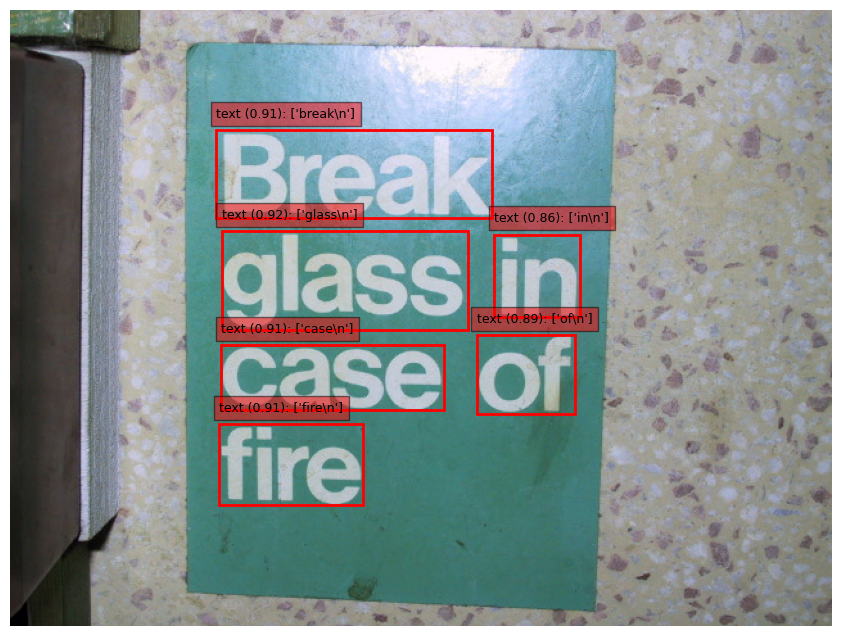

/content/SceneTrialTrain/lfsosa_12.08.2002/IMG_2669.JPG


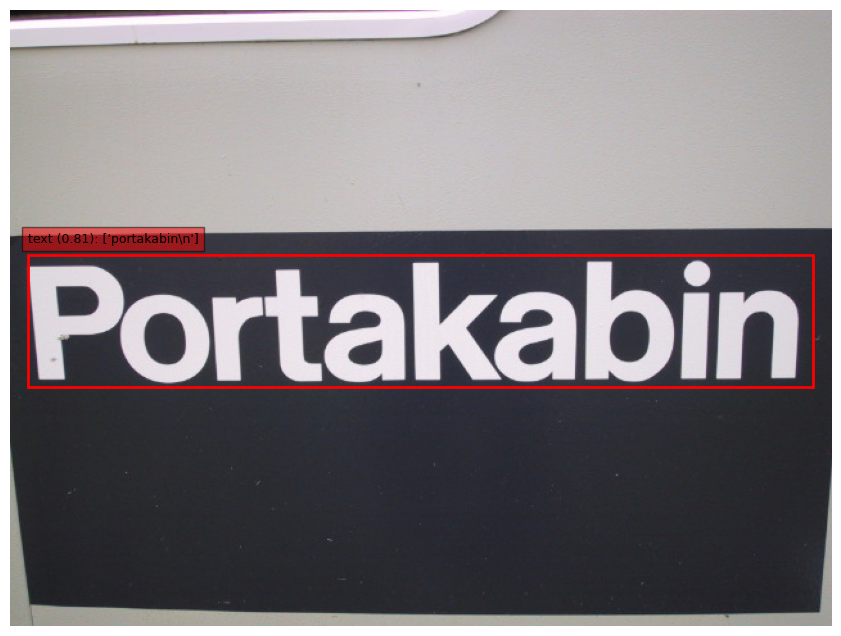

/content/SceneTrialTrain/lfsosa_12.08.2002/IMG_2594.JPG


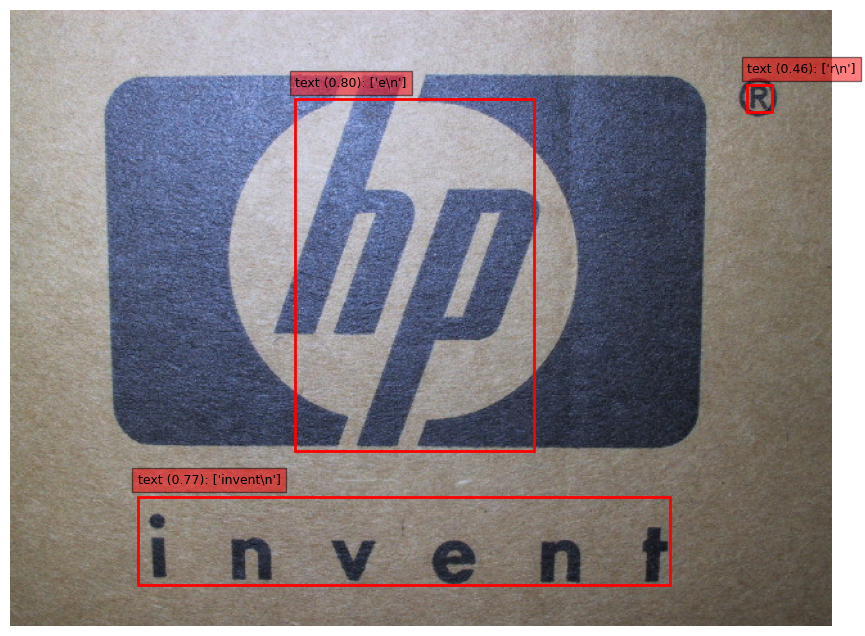

/content/SceneTrialTrain/lfsosa_12.08.2002/IMG_2460.JPG


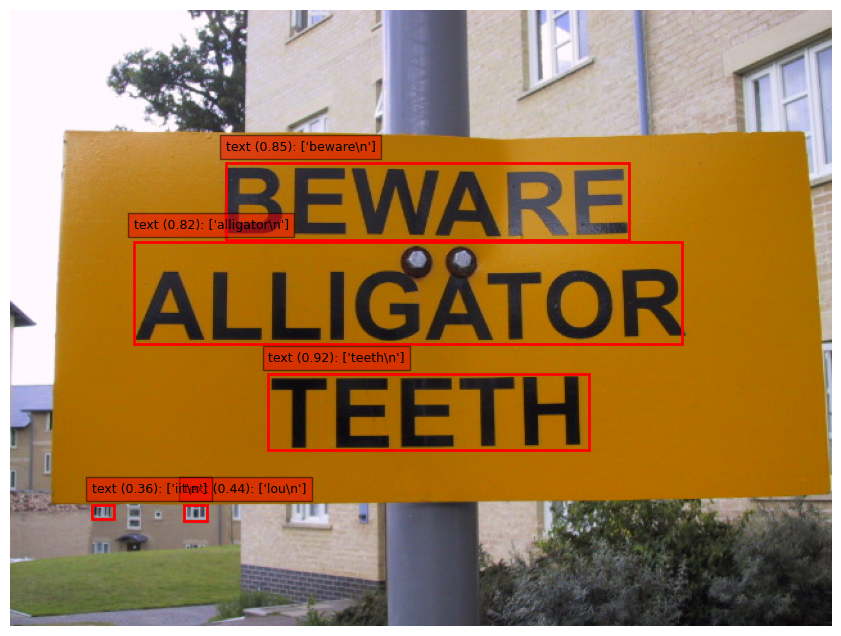

/content/SceneTrialTrain/lfsosa_12.08.2002/IMG_2472.JPG


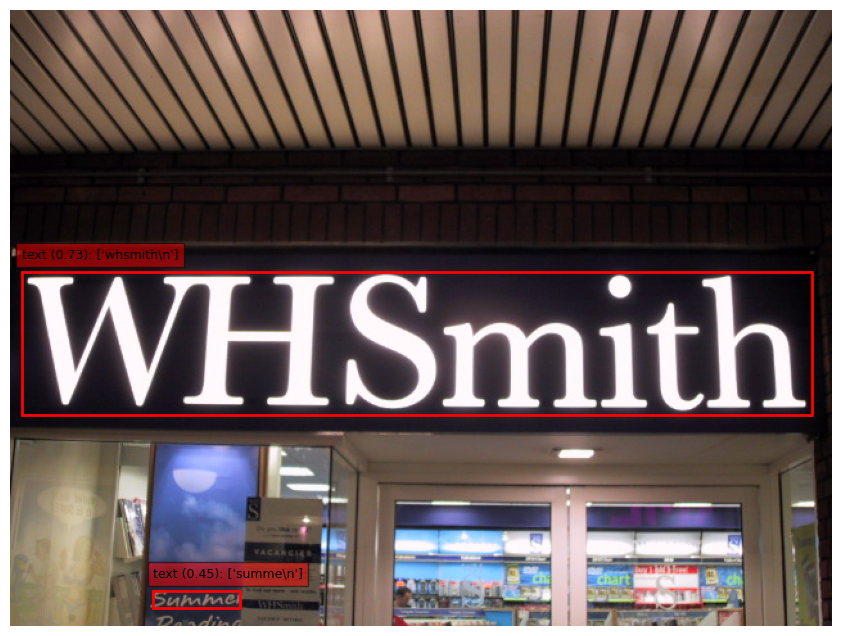

/content/SceneTrialTrain/lfsosa_12.08.2002/IMG_2628.JPG


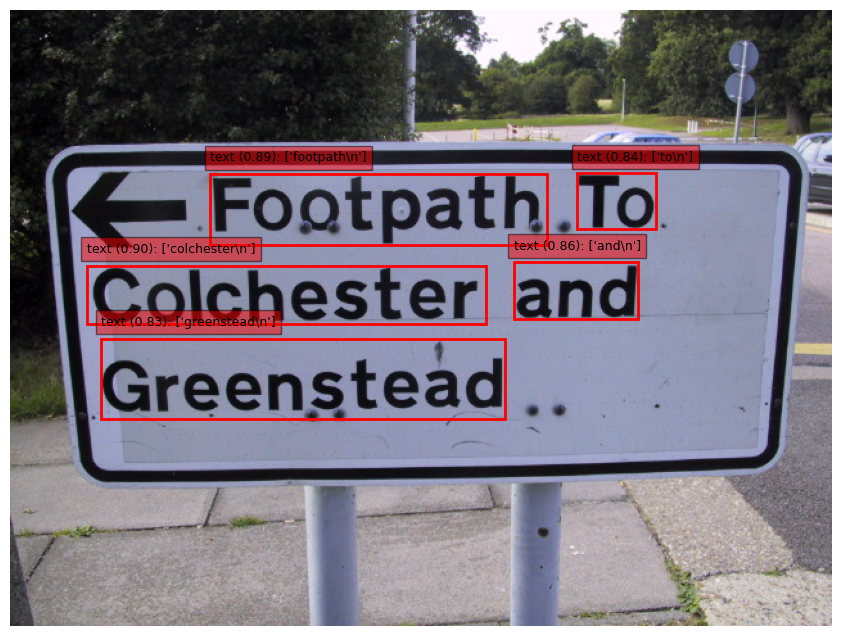

In [ ]:
img_dir = "/content/SceneTrialTrain/lfsosa_12.08.2002"
inf_transforms = data_transforms["val"]

for idx, img_filename in enumerate(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img_filename)
    print(img_path)
    predictions = predict(
        img_path,
        data_transforms=inf_transforms,
        text_detection_model=model_dectetion,
        text_recognition_model=crnn_model,
        idx_to_char=idx_to_char,
        device=device,
    )

    if idx == 5:
        break